In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# === 2. Load and transform data ===
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

def transform_dataset(bad_df):
    transformed_rows = []
    for _, row in bad_df.iterrows():
        for i in range(row['vsv_noemer']):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < row['vsv_teller'] else 0
            transformed_rows.append(new_row)
    df = pd.DataFrame(transformed_rows)
    return df.drop(columns=['vsv_noemer'])

df = transform_dataset(bad_df)
df.drop(columns=['schooljaar'], inplace=True, errors='ignore')

X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

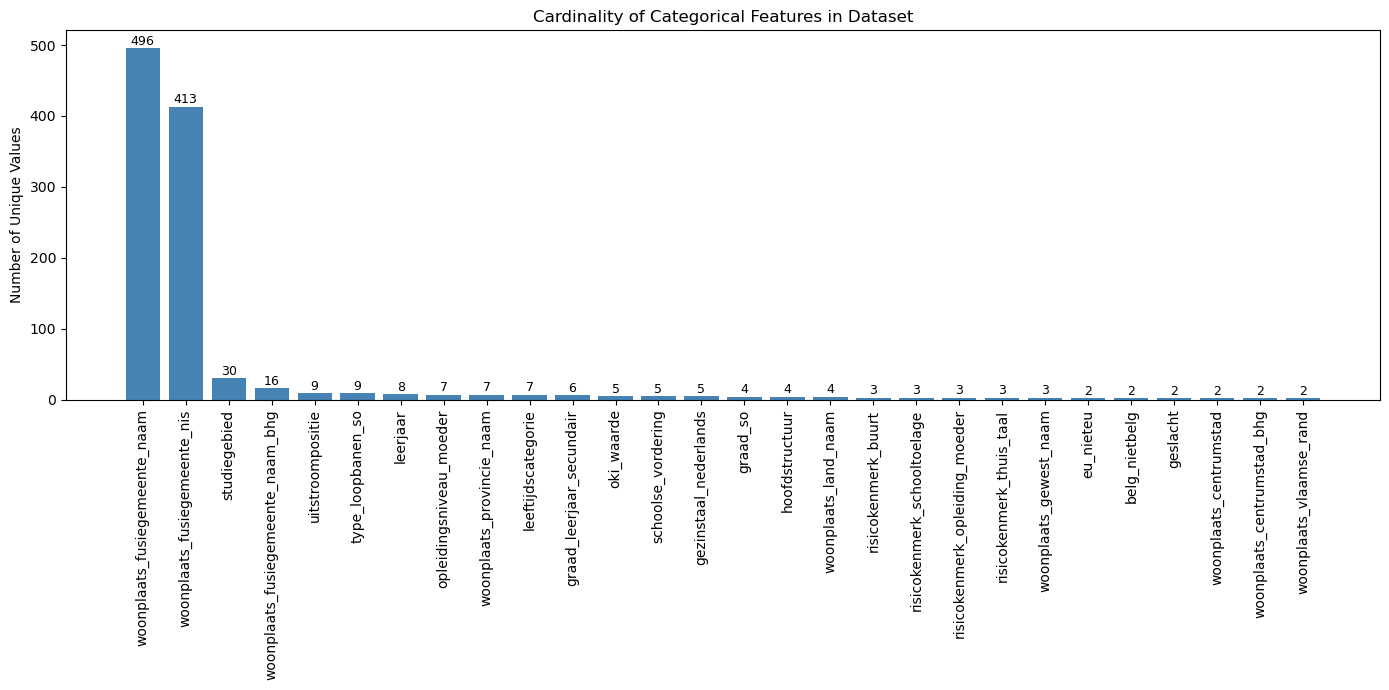

In [2]:
# Assuming df is your processed DataFrame
categorical_cols = df.select_dtypes(include='object').columns
cardinalities = {col: df[col].nunique() for col in categorical_cols}
cardinality_df = pd.DataFrame(cardinalities.items(), columns=['Feature', 'UniqueValues'])
cardinality_df = cardinality_df.sort_values(by='UniqueValues', ascending=False)

plt.figure(figsize=(14, 7))
bars = plt.bar(cardinality_df['Feature'], cardinality_df['UniqueValues'], color='steelblue')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=90)
plt.ylabel('Number of Unique Values')
plt.title('Cardinality of Categorical Features in Dataset')
plt.tight_layout()
plt.savefig("example_dataset_visual.png", dpi=300)
plt.show()

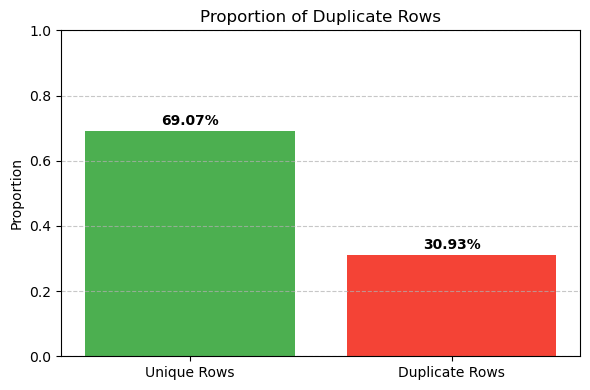

In [3]:
# Calculate duplicates
num_total = len(df)
num_duplicates = df.duplicated().sum()
duplicate_ratio = num_duplicates / num_total

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Unique Rows', 'Duplicate Rows'], [1 - duplicate_ratio, duplicate_ratio], color=['#4CAF50', '#F44336'])
plt.title("Proportion of Duplicate Rows")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([1 - duplicate_ratio, duplicate_ratio]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("duplicates_chart.png")
plt.show()

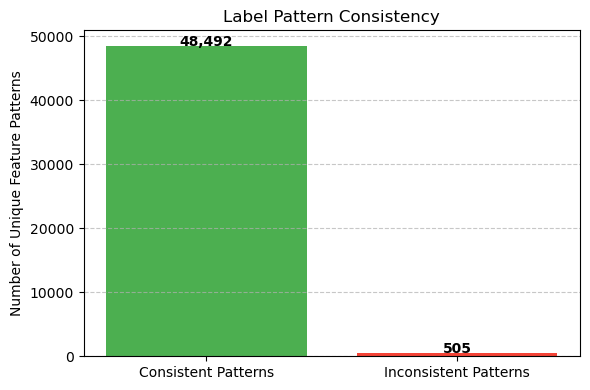

Total unique feature patterns: 48997
Inconsistent patterns: 505 (1.03%)
Inconsistent rows: 3345 out of 71668 (4.67%)


In [4]:
# Drop target column and get feature combinations
feature_cols = df.columns.drop('vsv_teller')
pattern_label_map = df.groupby(list(feature_cols))['vsv_teller'].nunique()

# Inconsistencies: more than one unique label for same feature combo
num_inconsistent_patterns = (pattern_label_map > 1).sum()
total_patterns = len(pattern_label_map)

# Now calculate how many rows are affected by those inconsistent patterns
inconsistent_patterns = pattern_label_map[pattern_label_map > 1].index
mask_inconsistent_rows = df[feature_cols].apply(tuple, axis=1).isin(inconsistent_patterns)
num_inconsistent_rows = mask_inconsistent_rows.sum()

# Plot
labels = ['Consistent Patterns', 'Inconsistent Patterns']
values = [total_patterns - num_inconsistent_patterns, num_inconsistent_patterns]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['#4CAF50', '#F44336'])
plt.title("Label Pattern Consistency")
plt.ylabel("Number of Unique Feature Patterns")
for i, v in enumerate(values):
    plt.text(i, v + 20, f"{v:,}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("label_inconsistencies.png")
plt.show()

# Print useful stats for reference in your thesis
print(f"Total unique feature patterns: {total_patterns}")
print(f"Inconsistent patterns: {num_inconsistent_patterns} ({num_inconsistent_patterns / total_patterns:.2%})")
print(f"Inconsistent rows: {num_inconsistent_rows} out of {len(df)} ({num_inconsistent_rows / len(df):.2%})")


C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\2896976846.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=province_counts.values, y=province_counts.index, palette="viridis")


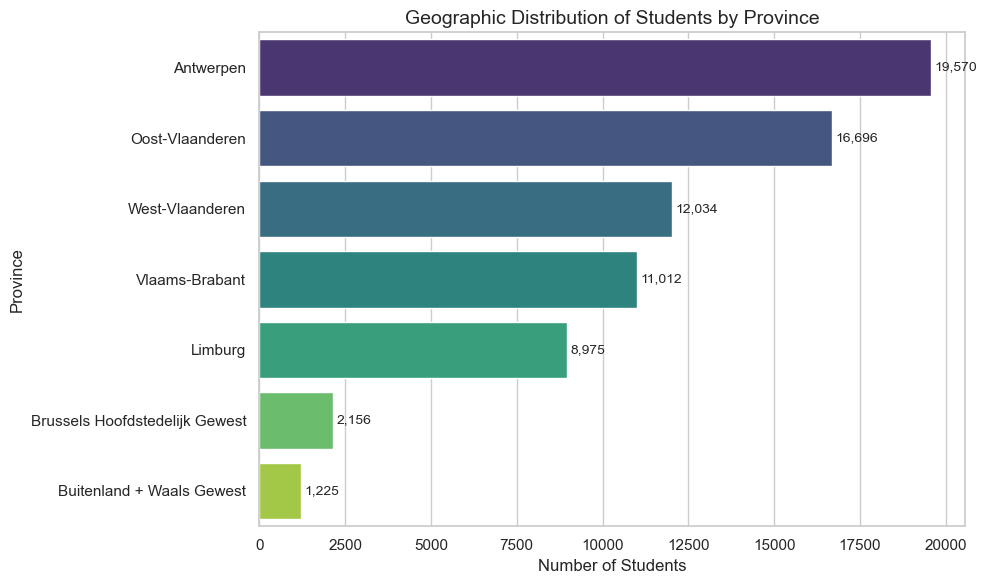

In [5]:
# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Count students per province
province_counts = df['woonplaats_provincie_naam'].value_counts().sort_values(ascending=False)

# Plot
sns.barplot(x=province_counts.values, y=province_counts.index, palette="viridis")
plt.title("Geographic Distribution of Students by Province", fontsize=14)
plt.xlabel("Number of Students", fontsize=12)
plt.ylabel("Province", fontsize=12)

# Add counts on bars
for i, count in enumerate(province_counts.values):
    plt.text(count + 100, i, f"{count:,}", va='center', fontsize=10)

plt.tight_layout()
plt.savefig("geographic_distribution.png")
plt.show()


C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\3595423435.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='Set2')
C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\3595423435.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\3595423435.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='Set2')
C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\3595423435.py:20: UserWarning: set_ticklabels() 

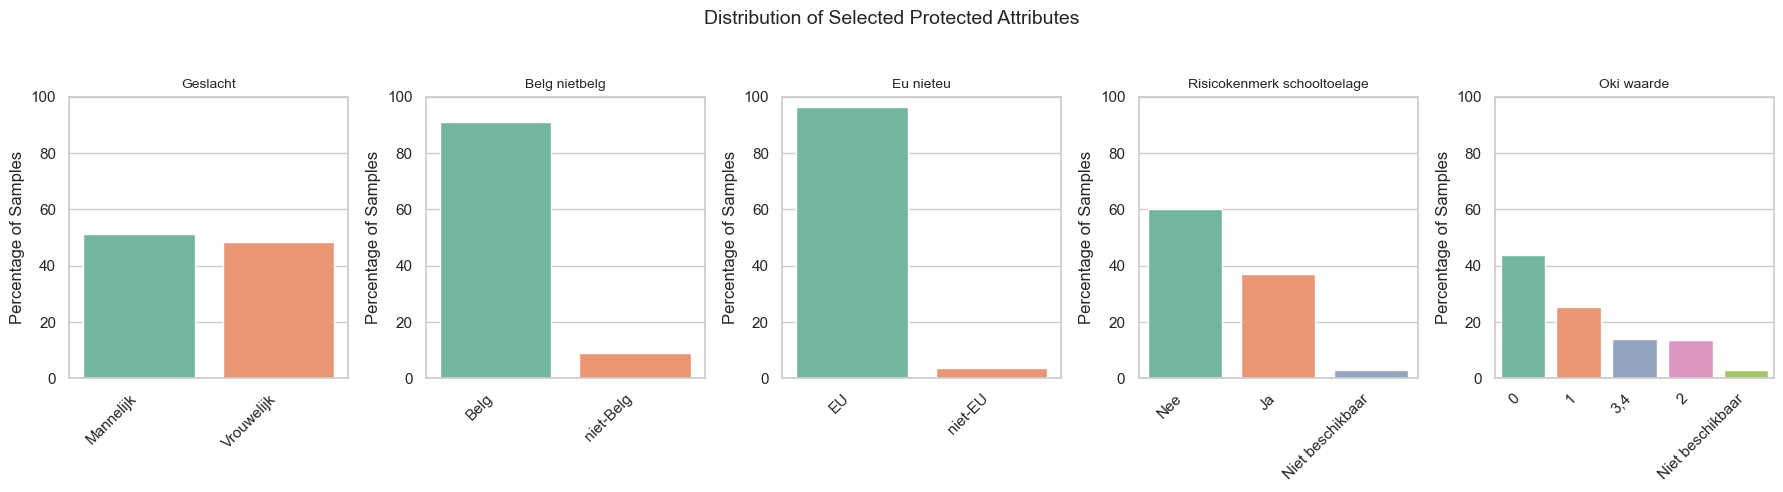

In [6]:
# Define protected columns you want to visualize
protected_features = [
    'geslacht',
    'belg_nietbelg',
    'eu_nieteu',
    'risicokenmerk_schooltoelage',
    'oki_waarde'
]

# Plotting
fig, axes = plt.subplots(1, len(protected_features), figsize=(18, 5), sharey=False)

for i, col in enumerate(protected_features):
    ax = axes[i]
    counts = df[col].value_counts(normalize=True).sort_values(ascending=False) * 100
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='Set2')
    ax.set_title(col.replace('_', ' ').capitalize(), fontsize=10)
    ax.set_ylabel('Percentage of Samples')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 100)

plt.suptitle('Distribution of Selected Protected Attributes', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('protected_distribution.png')
plt.show()

C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\3820537455.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vsv_teller', data=df, palette='viridis')


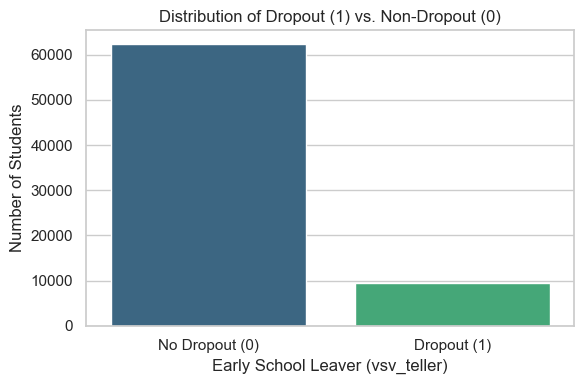

In [7]:
# Assuming df is already loaded and preprocessed
plt.figure(figsize=(6, 4))
sns.countplot(x='vsv_teller', data=df, palette='viridis')
plt.title('Distribution of Dropout (1) vs. Non-Dropout (0)')
plt.xlabel('Early School Leaver (vsv_teller)')
plt.ylabel('Number of Students')
plt.xticks([0, 1], ['No Dropout (0)', 'Dropout (1)'])
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\2209094258.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, ax=axes[i], order=df[feature].value_counts().index, palette='magma')
C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\2209094258.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, ax=axes[i], order=df[feature].value_counts().index, palette='magma')
C:\Users\mouni\AppData\Local\Temp\ipykernel_7772\2209094258.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, ax=a

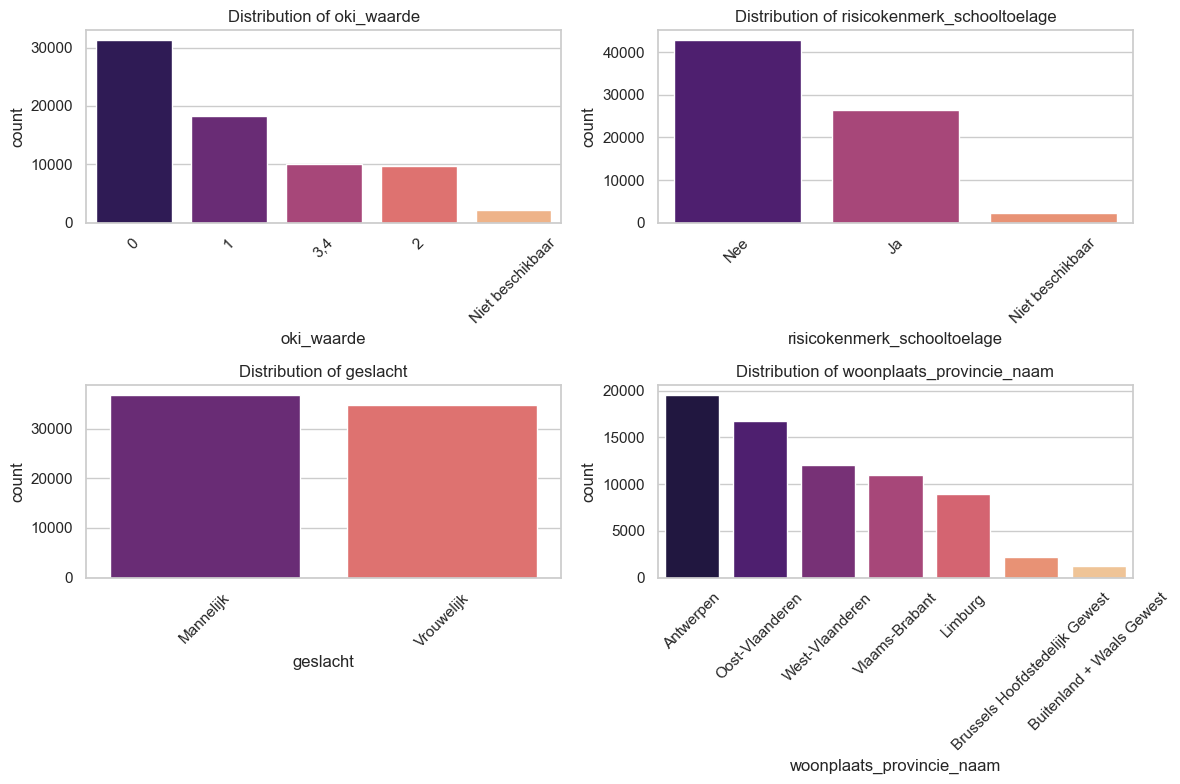

In [8]:
selected_features = [
    'oki_waarde',
    'risicokenmerk_schooltoelage',
    'geslacht',
    'woonplaats_provincie_naam'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.countplot(x=feature, data=df, ax=axes[i], order=df[feature].value_counts().index, palette='magma')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('feature_imbalance_grid.png', dpi=300)
plt.show()